In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from sklearn.model_selection import train_test_split

# Needed for API key
from dotenv import load_dotenv
import os
import requests

In [2]:
stock = 'GME'
load_dotenv()
key = os.getenv('key')

In [3]:
url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock}&apikey={key}'
r = requests.get(url)
data = r.json()

In [4]:
data['Meta Data']

{'1. Information': 'Daily Prices (open, high, low, close) and Volumes',
 '2. Symbol': 'GME',
 '3. Last Refreshed': '2025-03-28',
 '4. Output Size': 'Compact',
 '5. Time Zone': 'US/Eastern'}

In [5]:
gme_data = data['Time Series (Daily)']

In [6]:
df = pd.DataFrame.from_dict(gme_data, orient = 'index')
df.index = pd.to_datetime(df.index)
df = df.astype(float)
df = df.sort_index()
df

,1. open,2. high,3. low,4. close,5. volume
2024-11-01,22.400,23.050,22.0800,22.41,4744478.0
2024-11-04,22.200,22.650,21.8823,22.33,4300154.0
2024-11-05,22.320,23.200,22.2734,22.99,5858361.0
2024-11-06,23.310,23.820,22.9000,23.10,6648026.0
2024-11-07,23.070,23.655,22.8100,23.45,5554436.0
...,...,...,...,...,...
2025-03-24,25.350,25.830,25.1500,25.61,5036047.0
2025-03-25,25.700,25.770,24.9901,25.40,10106783.0
2025-03-26,28.840,29.800,27.3200,28.36,53312955.0
2025-03-27,25.865,26.280,21.1600,22.09,96733093.0


In [7]:
# get rid of 1s and 2s in front of column names
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

In [8]:
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.shape

(100, 5)

In [10]:
df.groupby(df.index.date).size()

2024-11-01    1
2024-11-04    1
2024-11-05    1
2024-11-06    1
2024-11-07    1
             ..
2025-03-24    1
2025-03-25    1
2025-03-26    1
2025-03-27    1
2025-03-28    1
Length: 100, dtype: int64

In [11]:
start_date = df.index.min().date().strftime('%Y%m%d')
end_date = df.index.max().date().strftime('%Y%m%d')

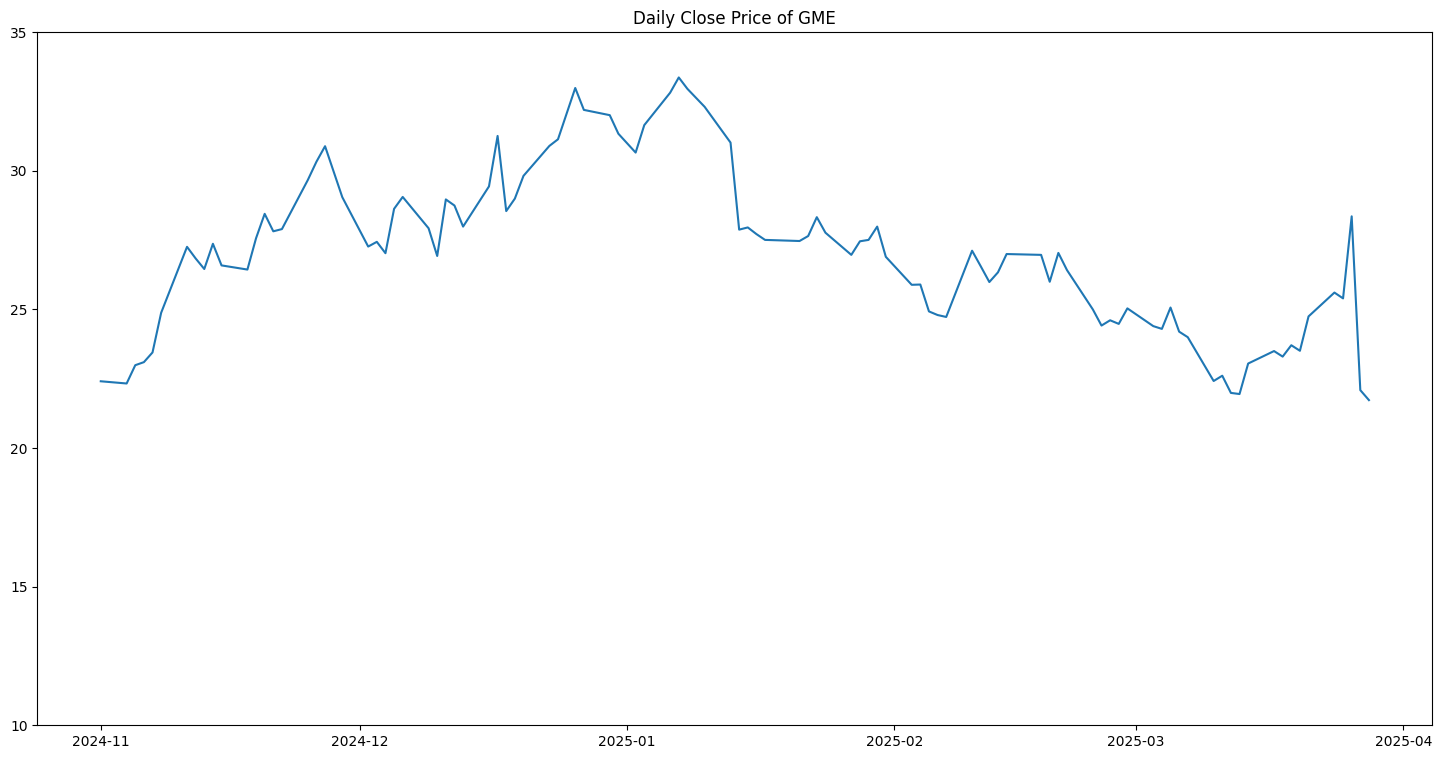

In [12]:
plt.figure(figsize = (18,9))
plt.plot(df['close'])
plt.title('Daily Close Price of GME')
plt.yticks(range(10,40,5));

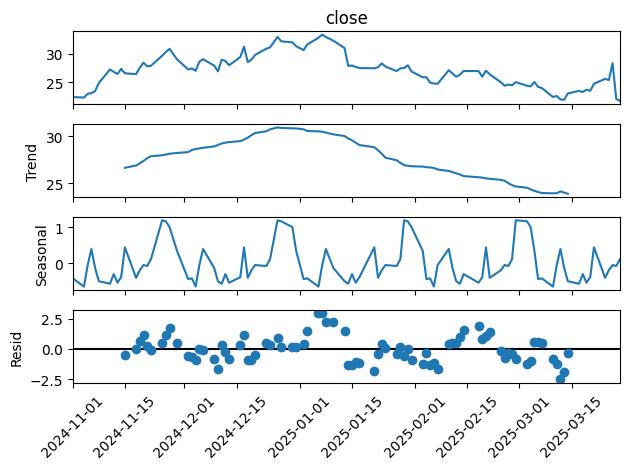

In [13]:
decomp = seasonal_decompose(df['close'],model='additive', period = 21)
fig = decomp.plot()

# Rotate only the Resid x-axis 45 degrees so it is legible
resid_ax = fig.axes[-1]
for label in resid_ax.get_xticklabels():
    label.set_rotation(45)

plt.tight_layout()
plt.show()

# Get in News

In [14]:
news_url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&tickers={stock}&time_from={start_date}T0000&time_to={end_date}T0000&apikey={key}'
r = requests.get(news_url)
data = r.json()

In [15]:
feed_items = data['feed']

In [16]:
feed_items

[{'title': 'GameStop Announces Pricing of Private Offering of $1.3 Billion of Convertible Senior Notes - GameStop  ( NYSE:GME ) ',
  'url': 'https://www.benzinga.com/pressreleases/25/03/g44526340/gamestop-announces-pricing-of-private-offering-of-1-3-billion-of-convertible-senior-notes',
  'time_published': '20250327T212749',
  'authors': ['Globe Newswire'],
  'summary': 'GRAPEVINE, Texas, March 27, 2025 ( GLOBE NEWSWIRE ) -- GameStop Corp.',
  'banner_image': 'https://www.benzinga.com/next-assets/images/schema-image-default.png',
  'source': 'Benzinga',
  'category_within_source': 'News',
  'source_domain': 'www.benzinga.com',
  'topics': [{'topic': 'Retail & Wholesale', 'relevance_score': '1.0'},
   {'topic': 'Financial Markets', 'relevance_score': '1.0'}],
  'overall_sentiment_score': 0.211668,
  'overall_sentiment_label': 'Somewhat-Bullish',
  'ticker_sentiment': [{'ticker': 'GME',
    'relevance_score': '0.64269',
    'ticker_sentiment_score': '0.309603',
    'ticker_sentiment_labe

In [17]:
flat_data = []

for article in feed_items:
    base = {
        'title': article.get('title'),
        'time_published': article.get('time_published'),
        'authors': ", ".join(article.get('authors', [])),
        'summary': article.get('summary'),
        'source': article.get('source'),
        'overall_sentiment_score': article.get('overall_sentiment_score'),
        'overall_sentiment_label': article.get('overall_sentiment_label'),
    }

    # Topics as comma-separated string
    topics = article.get('topics', [])
    topic_names = [t['topic'] for t in topics]
    base['topics'] = ", ".join(topic_names)

    # Ticker sentiment - multiple tickers possible, so one row per ticker
    for ticker_info in article.get('ticker_sentiment', []):
        if ticker_info.get('ticker') == stock:
            base['ticker'] = ticker_info.get('ticker')
            base['ticker_relevance_score'] = ticker_info.get('relevance_score')
            base['ticker_sentiment_score'] = ticker_info.get('ticker_sentiment_score')
            base['ticker_sentiment_label'] = ticker_info.get('ticker_sentiment_label')
            flat_data.append(base)
            break

news = pd.DataFrame(flat_data)

In [18]:
news

,title,time_published,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
0,GameStop Announces Pricing of Private Offering...,20250327T212749,Globe Newswire,"GRAPEVINE, Texas, March 27, 2025 ( GLOBE NEWSW...",Benzinga,0.211668,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.64269,0.309603,Somewhat-Bullish
1,GameStop Announces Pricing of Private Offering...,20250327T212700,GameStop Inc.,"GRAPEVINE, Texas, March 27, 2025 ( GLOBE NEWSW...",GlobeNewswire,0.209443,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.642275,0.319518,Somewhat-Bullish
2,$16.5B in Bitcoin options expire on Friday - W...,20250327T192000,Marcel Pechman,Bitcoin ( BTC ) investors are preparing for th...,Cointelegraph,0.240634,Somewhat-Bullish,"Economy - Monetary, Life Sciences, Retail & Wh...",GME,0.131643,0.191973,Somewhat-Bullish
3,GameStop wipes out $3B in market cap as stockh...,20250327T185954,Alex O’Donnell,GameStop shed nearly $3 billion in market capi...,Cointelegraph,-0.014457,Neutral,"Retail & Wholesale, Financial Markets, Technol...",GME,0.47672,0.07535,Neutral
4,RFK Jr. Plans Major Health Dept. Shakeup With ...,20250327T150400,Akanksha Bakshi,"RFK Jr. To Cut 10,000 Jobs, Shut Regional Agen...",Benzinga,-0.097721,Neutral,"Life Sciences, Technology, Economy - Monetary,...",GME,0.114865,-0.161832,Somewhat-Bearish
5,Why GameStop Sold Crypto Before Its Latest Bit...,20250327T144056,André Beganski,"In 2022 and 2023, GameStop saw $85 million in ...",Decrypt.co,0.068507,Neutral,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.514619,0.200256,Somewhat-Bullish
6,"Company News for Mar 27, 2025",20250327T133600,Zacks Equity Research,Companies in The News Are: ...,Zacks Commentary,0.091167,Neutral,"Earnings, Retail & Wholesale, Manufacturing",GME,0.588876,0.565474,Bullish
7,GameStop Stock Is Moving Lower Thursday: What'...,20250327T131716,Adam Eckert,GameStop announces plans to offer $1.3 billion...,Benzinga,0.192148,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.875188,0.332992,Somewhat-Bullish
8,French Blockchain Group's Bitcoin Holdings Ris...,20250327T124848,Vismaya V,The company's BTC buy puts it among the top 30...,Decrypt.co,0.256047,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.093653,0.0,Neutral
9,"GameStop shares drop, reversing Wednesday's ra...",20250327T124452,,The latest sell-off came after the video game ...,CNBC,0.265286,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Finance...",GME,0.510302,0.128915,Neutral


In [19]:
news.isnull().sum()

title                      0
time_published             0
authors                    0
summary                    0
source                     0
overall_sentiment_score    0
overall_sentiment_label    0
topics                     0
ticker                     0
ticker_relevance_score     0
ticker_sentiment_score     0
ticker_sentiment_label     0
dtype: int64

In [20]:
news.shape

(50, 12)

In [21]:
news['authors'].unique()

array(['Globe Newswire', 'GameStop Inc.', 'Marcel Pechman',
       'Alex O’Donnell', 'Akanksha Bakshi', 'André Beganski',
       'Zacks Equity Research', 'Adam Eckert', 'Vismaya V', '',
       'Avi Kapoor', 'Rishabh Mishra', 'Ciaran Lyons', 'Aniket Verma',
       'Shivdeep Dhaliwal', 'Shaun Pruitt', 'Christopher Tepedino',
       'David Bartosiak', 'Benzinga Insights', 'William Suberg',
       'Adrian Zmudzinski', 'Vince Dioquino', 'Sam Bourgi',
       'Stacy Elliott, André Beganski', 'Khyathi Dalal', 'Surbhi Jain'],
      dtype=object)

In [22]:
news['time_published'] = news['time_published'].str[:8]
news['time_published'] = pd.to_datetime(news['time_published'], format = '%Y%m%d')
news = news.set_index('time_published')

In [23]:
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-03-27,GameStop Announces Pricing of Private Offering...,Globe Newswire,"GRAPEVINE, Texas, March 27, 2025 ( GLOBE NEWSW...",Benzinga,0.211668,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.64269,0.309603,Somewhat-Bullish
2025-03-27,GameStop Announces Pricing of Private Offering...,GameStop Inc.,"GRAPEVINE, Texas, March 27, 2025 ( GLOBE NEWSW...",GlobeNewswire,0.209443,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.642275,0.319518,Somewhat-Bullish
2025-03-27,$16.5B in Bitcoin options expire on Friday - W...,Marcel Pechman,Bitcoin ( BTC ) investors are preparing for th...,Cointelegraph,0.240634,Somewhat-Bullish,"Economy - Monetary, Life Sciences, Retail & Wh...",GME,0.131643,0.191973,Somewhat-Bullish
2025-03-27,GameStop wipes out $3B in market cap as stockh...,Alex O’Donnell,GameStop shed nearly $3 billion in market capi...,Cointelegraph,-0.014457,Neutral,"Retail & Wholesale, Financial Markets, Technol...",GME,0.47672,0.07535,Neutral
2025-03-27,RFK Jr. Plans Major Health Dept. Shakeup With ...,Akanksha Bakshi,"RFK Jr. To Cut 10,000 Jobs, Shut Regional Agen...",Benzinga,-0.097721,Neutral,"Life Sciences, Technology, Economy - Monetary,...",GME,0.114865,-0.161832,Somewhat-Bearish
2025-03-27,Why GameStop Sold Crypto Before Its Latest Bit...,André Beganski,"In 2022 and 2023, GameStop saw $85 million in ...",Decrypt.co,0.068507,Neutral,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.514619,0.200256,Somewhat-Bullish
2025-03-27,"Company News for Mar 27, 2025",Zacks Equity Research,Companies in The News Are: ...,Zacks Commentary,0.091167,Neutral,"Earnings, Retail & Wholesale, Manufacturing",GME,0.588876,0.565474,Bullish
2025-03-27,GameStop Stock Is Moving Lower Thursday: What'...,Adam Eckert,GameStop announces plans to offer $1.3 billion...,Benzinga,0.192148,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.875188,0.332992,Somewhat-Bullish
2025-03-27,French Blockchain Group's Bitcoin Holdings Ris...,Vismaya V,The company's BTC buy puts it among the top 30...,Decrypt.co,0.256047,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.093653,0.0,Neutral


In [24]:
news.groupby(news.index.date).size()

2025-03-25     9
2025-03-26    23
2025-03-27    18
dtype: int64

In [25]:
news[news['authors'] == '']

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-03-27,"GameStop shares drop, reversing Wednesday's ra...",,The latest sell-off came after the video game ...,CNBC,0.265286,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Finance...",GME,0.510302,0.128915,Neutral
2025-03-26,Jim Cramer's top 10 things to watch in the sto...,,"Long lives are still out for Nvidia, and Meliu...",CNBC,0.087064,Neutral,"Economy - Fiscal, Retail & Wholesale, Financia...",GME,0.065327,0.139242,Neutral
2025-03-25,"GameStop to invest corporate cash in bitcoin, ...",,Video game retailer GameStop announced Tuesday...,CNBC,0.147312,Neutral,"Retail & Wholesale, Financial Markets, Earning...",GME,0.490323,0.16713,Somewhat-Bullish


In [26]:
news.loc[news['authors'] == '', 'authors'] = 'Unknown Author'
news

,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
time_published,,,,,,,,,,,
2025-03-27,GameStop Announces Pricing of Private Offering...,Globe Newswire,"GRAPEVINE, Texas, March 27, 2025 ( GLOBE NEWSW...",Benzinga,0.211668,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.64269,0.309603,Somewhat-Bullish
2025-03-27,GameStop Announces Pricing of Private Offering...,GameStop Inc.,"GRAPEVINE, Texas, March 27, 2025 ( GLOBE NEWSW...",GlobeNewswire,0.209443,Somewhat-Bullish,"Retail & Wholesale, Financial Markets",GME,0.642275,0.319518,Somewhat-Bullish
2025-03-27,$16.5B in Bitcoin options expire on Friday - W...,Marcel Pechman,Bitcoin ( BTC ) investors are preparing for th...,Cointelegraph,0.240634,Somewhat-Bullish,"Economy - Monetary, Life Sciences, Retail & Wh...",GME,0.131643,0.191973,Somewhat-Bullish
2025-03-27,GameStop wipes out $3B in market cap as stockh...,Alex O’Donnell,GameStop shed nearly $3 billion in market capi...,Cointelegraph,-0.014457,Neutral,"Retail & Wholesale, Financial Markets, Technol...",GME,0.47672,0.07535,Neutral
2025-03-27,RFK Jr. Plans Major Health Dept. Shakeup With ...,Akanksha Bakshi,"RFK Jr. To Cut 10,000 Jobs, Shut Regional Agen...",Benzinga,-0.097721,Neutral,"Life Sciences, Technology, Economy - Monetary,...",GME,0.114865,-0.161832,Somewhat-Bearish
2025-03-27,Why GameStop Sold Crypto Before Its Latest Bit...,André Beganski,"In 2022 and 2023, GameStop saw $85 million in ...",Decrypt.co,0.068507,Neutral,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.514619,0.200256,Somewhat-Bullish
2025-03-27,"Company News for Mar 27, 2025",Zacks Equity Research,Companies in The News Are: ...,Zacks Commentary,0.091167,Neutral,"Earnings, Retail & Wholesale, Manufacturing",GME,0.588876,0.565474,Bullish
2025-03-27,GameStop Stock Is Moving Lower Thursday: What'...,Adam Eckert,GameStop announces plans to offer $1.3 billion...,Benzinga,0.192148,Somewhat-Bullish,"Earnings, Retail & Wholesale, Financial Markets",GME,0.875188,0.332992,Somewhat-Bullish
2025-03-27,French Blockchain Group's Bitcoin Holdings Ris...,Vismaya V,The company's BTC buy puts it among the top 30...,Decrypt.co,0.256047,Somewhat-Bullish,"Retail & Wholesale, Financial Markets, Technol...",GME,0.093653,0.0,Neutral


In [27]:
news['overall_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Neutral', 'Bullish'], dtype=object)

In [28]:
news['ticker_sentiment_label'].unique()

array(['Somewhat-Bullish', 'Neutral', 'Somewhat-Bearish', 'Bullish'],
      dtype=object)

In [29]:
news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})
news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({
    'Somewhat-Bullish': 4, 
    'Neutral': 3, 
    'Bullish': 5, 
    'Somewhat-Bearish': 2,
    'Bearish': 1
})

C:\Users\graha\AppData\Local\Temp\ipykernel_8164\3453675565.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['overall_sentiment_label'] = news['overall_sentiment_label'].replace({
C:\Users\graha\AppData\Local\Temp\ipykernel_8164\3453675565.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  news['ticker_sentiment_label'] = news['ticker_sentiment_label'].replace({


# Merge both DataFrames

In [30]:
merged_df = df.merge(news,how = 'left',left_index = True, right_index = True)
merged_df = merged_df.fillna(0)
merged_df

,open,high,low,close,volume,title,authors,summary,source,overall_sentiment_score,overall_sentiment_label,topics,ticker,ticker_relevance_score,ticker_sentiment_score,ticker_sentiment_label
2024-11-01,22.400,23.050,22.0800,22.41,4744478.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-11-04,22.200,22.650,21.8823,22.33,4300154.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-11-05,22.320,23.200,22.2734,22.99,5858361.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-11-06,23.310,23.820,22.9000,23.10,6648026.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
2024-11-07,23.070,23.655,22.8100,23.45,5554436.0,0,0,0,0,0.000000,0.0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,25.865,26.280,21.1600,22.09,96733093.0,"TD SYNNEX, Lululemon Athletica And 3 Stocks To...",Avi Kapoor,With U.S. stock futures trading higher this mo...,Benzinga,0.323341,4.0,"Retail & Wholesale, Financial Markets, Manufac...",GME,0.414559,0.307711,4.0
2025-03-27,25.865,26.280,21.1600,22.09,96733093.0,The Blockchain Group adds 580 BTC as stock jum...,Ciaran Lyons,France-based The Blockchain Group has added an...,Cointelegraph,0.201323,4.0,"Retail & Wholesale, Financial Markets, Technol...",GME,0.252987,0.100678,3.0
2025-03-27,25.865,26.280,21.1600,22.09,96733093.0,"GameStop-Themed Memecoin Takes Sharp U-Turn, T...",Aniket Verma,A cryptocurrency named after GameStop Corp. GM...,Benzinga,0.209804,4.0,"Retail & Wholesale, Blockchain, Financial Markets",GME,0.807885,0.280065,4.0
2025-03-27,25.865,26.280,21.1600,22.09,96733093.0,"NVDA, GME, F, RIVN, TSLA: Top 5 Trending Stock...",Shivdeep Dhaliwal,U.S. stock markets experienced a downturn on W...,Benzinga,-0.060692,3.0,"Retail & Wholesale, Financial Markets",GME,0.089129,-0.005282,3.0


In [41]:
look_back = 10
X = merged_df.drop(columns = ['title','topics','ticker','close','authors','summary','source'])
y = merged_df['close']
X_train, X_test, y_train, y_test = train_test_split(X,y,shuffle = False)
# need to split in such a way that both resulting numbers are divisible by the look_back

In [ ]:
X_train = np.array(X_train).reshape(-1, look_back, 9)
X_test = np.array(X_test).reshape(-1, look_back, 9)

In [ ]:
model = Sequential()
model.add(LSTM(25, return_sequences=True, input_shape=(look_back, X_train.shape[2])))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=1000, batch_size=240, verbose=1)

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(12, 6))
plt.plot(y_test, label="Actual Stock Prices", color="blue")
plt.plot(y_pred, label="Predicted Stock Prices", color="red", linestyle="dashed")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Actual vs. Predicted Stock Prices (Using News Sentiment)")
plt.legend()
plt.show()